In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import differential_evolution
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("optimized_data.csv")
df = df[df['result'] == 'success']
df.drop(columns="result", inplace=True)
df.columns

Index(['LUTs', 'Registers', 'BRAMs', 'DSPs', 'WNS (ns)', 'Total Power (W)',
       'Dynamic Power (W)', 'Static Power (W)', 'Cycles', 'Clock Period',
       'Frac Width', 'Num Parallel', 'Int Bits', 'D', 'H', 'MAE', 'RMSE',
       'Execution Time (m)', 'Time Utilization'],
      dtype='object')

In [3]:
df.rename(columns={'Clock Period': 'Clock Period (ns)'}, inplace=True)
df.columns

Index(['LUTs', 'Registers', 'BRAMs', 'DSPs', 'WNS (ns)', 'Total Power (W)',
       'Dynamic Power (W)', 'Static Power (W)', 'Cycles', 'Clock Period (ns)',
       'Frac Width', 'Num Parallel', 'Int Bits', 'D', 'H', 'MAE', 'RMSE',
       'Execution Time (m)', 'Time Utilization'],
      dtype='object')

In [4]:
slices = 15850
lut_per_slice = 4
registers_per_slice = 8

luts = slices * lut_per_slice
registers = slices * registers_per_slice
dsps = 240

df["Average Utilization"] = ( ( df["LUTs"] / luts ) + ( df["Registers"] / registers ) + ( df["DSPs"] / dsps ) ) / 3

In [5]:
signal_period = 1000000 / 30
df["Clock Period Utilization"] = ( ( df["Clock Period (ns)"] - df["WNS (ns)"]) / df["Clock Period (ns)"] ) * 100
df["Cycle Utilization"] = ( ( df["Clock Period (ns)"] * df["Cycles"] ) / signal_period ) * 100
df["Time Utilization"] = df["Clock Period Utilization"] * df["Cycle Utilization"]

In [6]:
independant_variables = [
    "Frac Width", "Num Parallel"
]

dependant_variables = [
    "WNS (ns)", "LUTs", "Registers", "DSPs", "Cycles",
    "MAE", "RMSE", "Average Utilization", "Clock Period Utilization", "Cycle Utilization", "Time Utilization"
]

In [7]:
chunk_size = 20  # number of rows per image

for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    dfi.export(chunk, f"df_chunk_{i}.png", table_conversion='chrome')

df

,LUTs,Registers,BRAMs,DSPs,WNS (ns),Total Power (W),Dynamic Power (W),Static Power (W),Cycles,Clock Period (ns),...,Int Bits,D,H,MAE,RMSE,Execution Time (m),Time Utilization,Average Utilization,Clock Period Utilization,Cycle Utilization
0,39027,701,0,258,0.187,3.081,0.135,2.947,84.0,10,...,10.0,64,16,0.761401,0.919491,9.888221,247.2876,0.565365,98.13,2.52
1,41876,1075,0,258,-0.395,3.085,0.138,2.947,84.0,10,...,10.0,64,16,1.010069,1.157455,14.484323,261.9540,0.581328,103.95,2.52
2,46148,1302,0,258,0.004,3.108,0.161,2.947,84.0,10,...,10.0,64,16,0.939092,1.072240,17.314494,251.8992,0.604385,99.96,2.52
3,48736,1402,0,258,-0.854,3.118,0.171,2.947,84.0,10,...,10.0,64,16,0.640024,0.759434,16.701628,273.5208,0.618254,108.54,2.52
4,52483,1511,0,258,-0.587,3.091,0.144,2.947,84.0,10,...,10.0,64,16,0.278057,0.356037,18.684067,266.7924,0.638241,105.87,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,133816,2961,0,4128,-2.074,3.760,0.801,2.959,24.0,10,...,10.0,64,16,0.024583,0.041842,43.651829,86.9328,6.444671,120.74,0.72
73,321557,3126,0,4128,-3.757,3.768,0.809,2.959,24.0,10,...,10.0,64,16,0.021945,0.040050,44.192764,99.0504,7.432177,137.57,0.72
74,416509,3287,0,4128,-4.651,3.746,0.787,2.959,24.0,10,...,10.0,64,16,0.021600,0.039951,53.274120,105.4872,7.931822,146.51,0.72
75,516223,3448,0,4128,-4.048,3.825,0.864,2.960,24.0,10,...,10.0,64,16,0.021691,0.040141,57.556757,101.1456,8.456504,140.48,0.72


In [8]:
df[(df["Frac Width"] <= 7) & (df["LUTs"] <= 63400)]

,LUTs,Registers,BRAMs,DSPs,WNS (ns),Total Power (W),Dynamic Power (W),Static Power (W),Cycles,Clock Period (ns),...,Int Bits,D,H,MAE,RMSE,Execution Time (m),Time Utilization,Average Utilization,Clock Period Utilization,Cycle Utilization
0,39027,701,0,258,0.187,3.081,0.135,2.947,84.0,10,...,10.0,64,16,0.761401,0.919491,9.888221,247.2876,0.565365,98.13,2.52
1,41876,1075,0,258,-0.395,3.085,0.138,2.947,84.0,10,...,10.0,64,16,1.010069,1.157455,14.484323,261.9540,0.581328,103.95,2.52
2,46148,1302,0,258,0.004,3.108,0.161,2.947,84.0,10,...,10.0,64,16,0.939092,1.072240,17.314494,251.8992,0.604385,99.96,2.52
3,48736,1402,0,258,-0.854,3.118,0.171,2.947,84.0,10,...,10.0,64,16,0.640024,0.759434,16.701628,273.5208,0.618254,108.54,2.52
4,52483,1511,0,258,-0.587,3.091,0.144,2.947,84.0,10,...,10.0,64,16,0.278057,0.356037,18.684067,266.7924,0.638241,105.87,2.52
5,56023,1610,0,258,-0.967,3.097,0.150,2.947,84.0,10,...,10.0,64,16,0.121893,0.162203,23.357364,276.3684,0.657114,109.67,2.52
6,59645,1729,0,258,-1.137,3.135,0.187,2.948,84.0,10,...,10.0,64,16,0.058267,0.080977,18.589155,280.6524,0.676470,111.37,2.52
16,43163,682,0,516,0.320,3.114,0.167,2.947,52.0,10,...,10.0,64,16,0.761401,0.919491,9.851929,151.0080,0.945394,96.80,1.56
17,47847,1079,0,516,0.053,3.123,0.176,2.948,52.0,10,...,10.0,64,16,1.010069,1.157455,23.216270,155.1732,0.971065,99.47,1.56
18,52480,1307,0,516,0.036,3.112,0.164,2.947,52.0,10,...,10.0,64,16,0.939092,1.072240,16.887733,155.4384,0.996023,99.64,1.56


In [9]:
df[(df["Frac Width"] == 7) & (df["LUTs"] <= 63400)]

,LUTs,Registers,BRAMs,DSPs,WNS (ns),Total Power (W),Dynamic Power (W),Static Power (W),Cycles,Clock Period (ns),...,Int Bits,D,H,MAE,RMSE,Execution Time (m),Time Utilization,Average Utilization,Clock Period Utilization,Cycle Utilization
6,59645,1729,0,258,-1.137,3.135,0.187,2.948,84.0,10,...,10.0,64,16,0.058267,0.080977,18.589155,280.6524,0.67647,111.37,2.52


In [20]:
df.iloc[6]

LUTs                        59645.000000
Registers                    1729.000000
BRAMs                           0.000000
DSPs                          258.000000
WNS (ns)                       -1.137000
Total Power (W)                 3.135000
Dynamic Power (W)               0.187000
Static Power (W)                2.948000
Cycles                         84.000000
Clock Period (ns)              10.000000
Frac Width                      7.000000
Num Parallel                    1.000000
Int Bits                       10.000000
D                              64.000000
H                              16.000000
MAE                             0.058267
RMSE                            0.080977
Execution Time (m)             18.589155
Time Utilization              280.652400
Average Utilization             0.676470
Clock Period Utilization      111.370000
Cycle Utilization               2.520000
Name: 6, dtype: float64

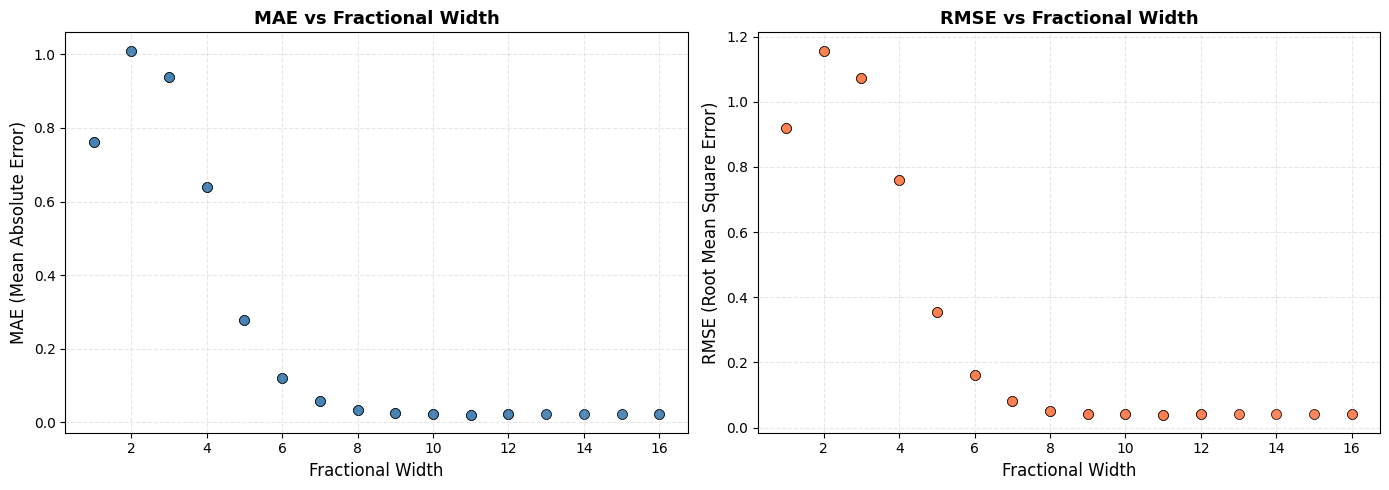

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE plot
axes[0].scatter(df['Frac Width'], df['MAE'], alpha=0.6, s=50, 
                edgecolors='black', linewidth=0.5, color='steelblue')
axes[0].set_xlabel('Fractional Width', fontsize=12)
axes[0].set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
axes[0].set_title('MAE vs Fractional Width', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')

# RMSE plot
axes[1].scatter(df['Frac Width'], df['RMSE'], alpha=0.6, s=50, 
                edgecolors='black', linewidth=0.5, color='coral')
axes[1].set_xlabel('Fractional Width', fontsize=12)
axes[1].set_ylabel('RMSE (Root Mean Square Error)', fontsize=12)
axes[1].set_title('RMSE vs Fractional Width', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

In [11]:
def plot_and_save(df, x_col, y_col, output_filename=None):
    """
    Create a scatter plot and save it as a PNG file.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    x_col : str
        Column name for x-axis
    y_col : str
        Column name for y-axis
    output_filename : str, optional
        Output filename (without extension). If None, uses 'x_col_vs_y_col.png'
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create scatter plot
    ax.scatter(df[x_col], df[y_col], alpha=0.6, s=50, 
               edgecolors='black', linewidth=0.5, color='coral')
    
    # Set labels and title
    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel(y_col, fontsize=12)
    ax.set_title(f'{y_col} vs {x_col}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Generate filename if not provided
    if output_filename is None:
        output_filename = f'plot_{y_col}_vs_{x_col}.png'
    elif not output_filename.endswith('.png'):
        output_filename += '.png'
    
    # Save the figure
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f'Plot saved as: {output_filename}')
    
    plt.close()

# Usage examples:
for i in independant_variables:
    for d in dependant_variables:
        plot_and_save(df, i, d)

Plot saved as: plot_WNS (ns)_vs_Frac Width.png
Plot saved as: plot_LUTs_vs_Frac Width.png
Plot saved as: plot_Registers_vs_Frac Width.png
Plot saved as: plot_DSPs_vs_Frac Width.png
Plot saved as: plot_Cycles_vs_Frac Width.png
Plot saved as: plot_MAE_vs_Frac Width.png
Plot saved as: plot_RMSE_vs_Frac Width.png
Plot saved as: plot_Average Utilization_vs_Frac Width.png
Plot saved as: plot_Clock Period Utilization_vs_Frac Width.png
Plot saved as: plot_Cycle Utilization_vs_Frac Width.png
Plot saved as: plot_Time Utilization_vs_Frac Width.png
Plot saved as: plot_WNS (ns)_vs_Num Parallel.png
Plot saved as: plot_LUTs_vs_Num Parallel.png
Plot saved as: plot_Registers_vs_Num Parallel.png
Plot saved as: plot_DSPs_vs_Num Parallel.png
Plot saved as: plot_Cycles_vs_Num Parallel.png
Plot saved as: plot_MAE_vs_Num Parallel.png
Plot saved as: plot_RMSE_vs_Num Parallel.png
Plot saved as: plot_Average Utilization_vs_Num Parallel.png
Plot saved as: plot_Clock Period Utilization_vs_Num Parallel.png
Plot sa

In [12]:
df_unique_mae = df.drop_duplicates(subset=['MAE', 'Frac Width'])
lowest_mae = df_unique_mae.nsmallest(20, 'MAE')
lowest_mae[["MAE", "Frac Width"]].head(20)

,MAE,Frac Width
10,0.021600,11.0
11,0.021691,12.0
28,0.021823,13.0
29,0.021937,14.0
9,0.021945,10.0
30,0.022014,15.0
31,0.022040,16.0
8,0.024583,9.0
7,0.033575,8.0
6,0.058267,7.0


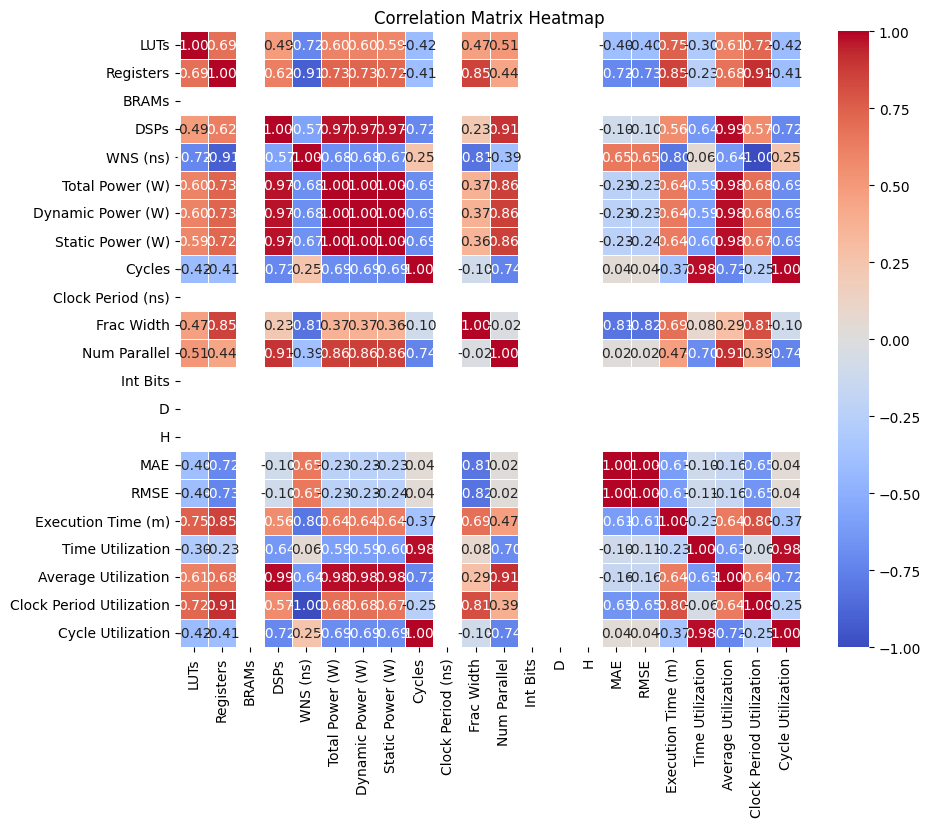

<Figure size 640x480 with 0 Axes>

In [13]:
corr = df.corr()

# Set up the plot
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(
    corr,
    annot=True,          # show correlation values
    fmt=".2f",           # format numbers
    cmap="coolwarm",     # color palette
    linewidths=0.5
)

plt.title("Correlation Matrix Heatmap")
plt.show()
plt.savefig("corr_matrix.png")

In [14]:
desc = df[independant_variables + dependant_variables].describe()
desc = desc.drop('count').round(2)

styled_desc = desc.style.format(precision=2)
dfi.export(styled_desc, "describe_output.png", table_conversion='chrome')
desc

,Frac Width,Num Parallel,WNS (ns),LUTs,Registers,DSPs,Cycles,MAE,RMSE,Average Utilization,Clock Period Utilization,Cycle Utilization,Time Utilization
mean,7.95,6.08,-1.41,110749.26,2062.26,1823.67,43.51,0.27,0.33,3.12,114.13,1.31,146.99
std,4.47,5.25,1.28,80894.75,706.39,1612.55,20.59,0.36,0.42,2.48,12.85,0.62,67.34
min,1.00,1.00,-4.65,39027.00,682.00,258.00,24.00,0.02,0.04,0.57,96.80,0.72,74.48
25%,4.00,2.00,-2.19,65894.00,1585.00,516.00,28.00,0.02,0.04,1.07,102.85,0.84,99.05
50%,8.00,4.00,-1.20,92289.00,2043.00,1032.00,36.00,0.03,0.05,1.99,111.95,1.08,116.96
75%,11.00,8.00,-0.28,118163.00,2533.00,2064.00,52.00,0.64,0.76,4.19,121.91,1.56,180.09
max,16.00,16.00,0.32,516223.00,4082.00,8256.00,84.00,1.01,1.16,12.42,146.51,2.52,311.80


In [15]:
# Check which columns have zero variance
print("\nColumns with zero variance:")
for col in df.columns:
    if df[col].nunique() <= 1:
        print(f"  {col}: {df[col].unique()}")


Columns with zero variance:
  BRAMs: [0]
  Clock Period (ns): [10]
  Int Bits: [10.]
  D: [64]
  H: [16]


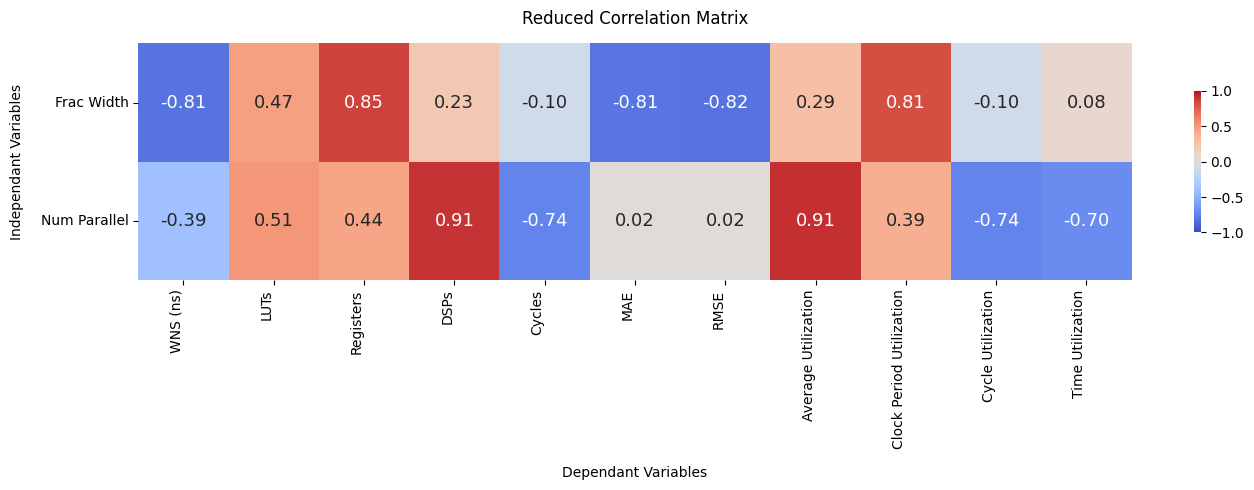

In [16]:
set_bottom = dependant_variables
set_right = independant_variables

A = df[set_right].values
B = df[set_bottom].values

corr = np.corrcoef(A.T, B.T)
corr_mat = corr[:len(set_right), len(set_right):]

corr_df = pd.DataFrame(corr_mat, index=set_right, columns=set_bottom)

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 5))   # wider figure to fit long x-labels

# Plot heatmap
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    ax=ax,
    cbar_kws={"shrink": 0.6},
    annot_kws={"fontsize": 13}              # reduce annotation font size if crowded
)

# Tweak tick labels so they don't get cut off
ax.set_xlabel("Dependant Variables", labelpad=12)
ax.set_ylabel("Independant Variables", labelpad=12)
ax.set_title("Reduced Correlation Matrix", pad=14)

# Rotate and right-align x tick labels (long names)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)

# Optionally reduce x tick label font size if still crowded
for tick in ax.get_xticklabels():
    tick.set_fontsize(10)

# Tight layout and save without clipping
plt.tight_layout()
plt.savefig("reduced_corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

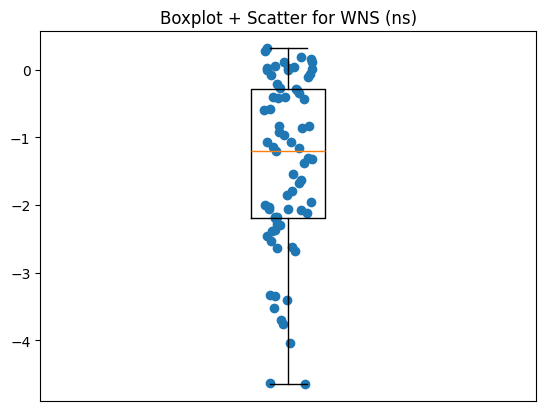

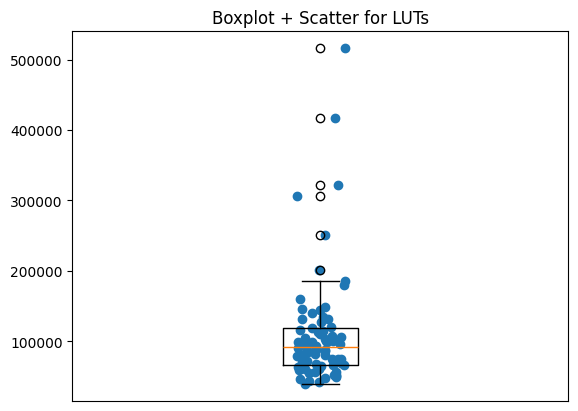

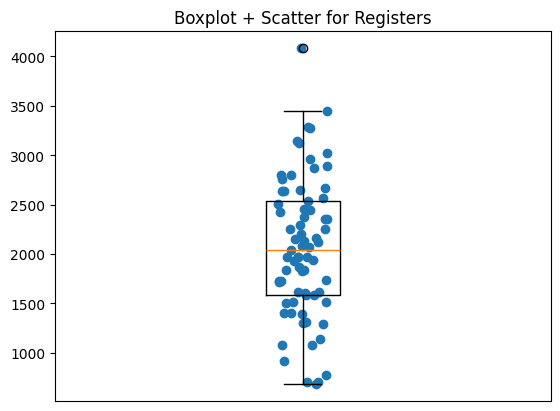

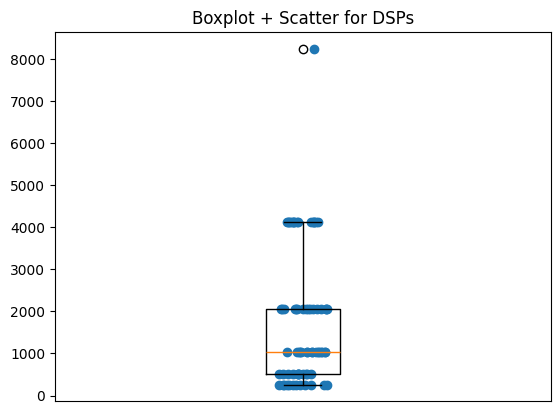

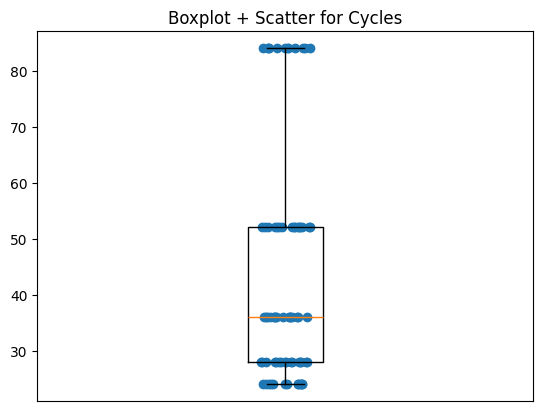

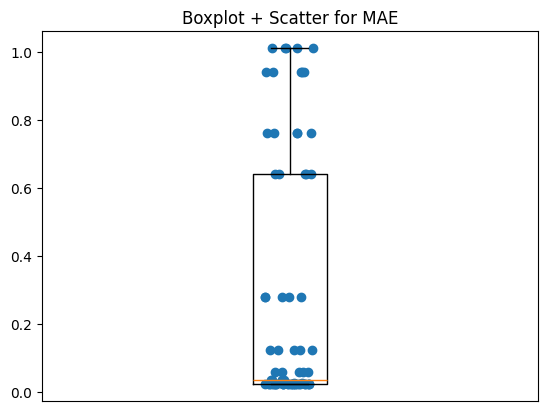

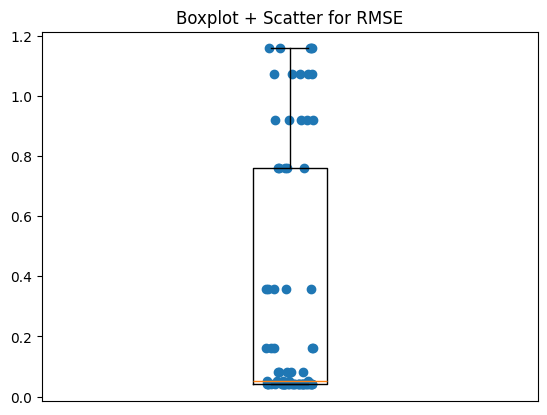

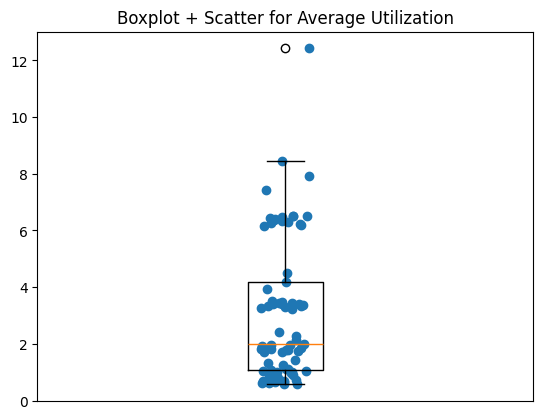

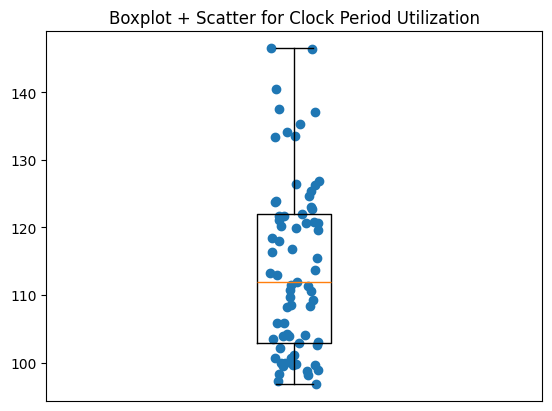

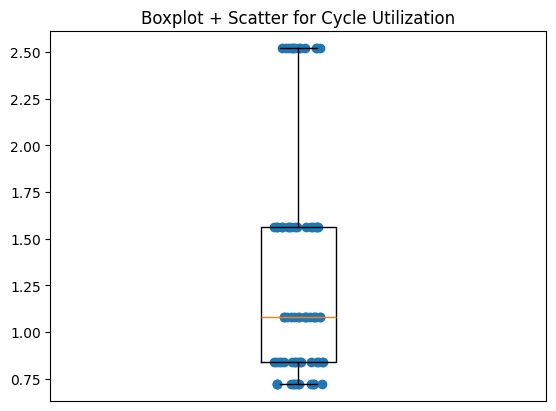

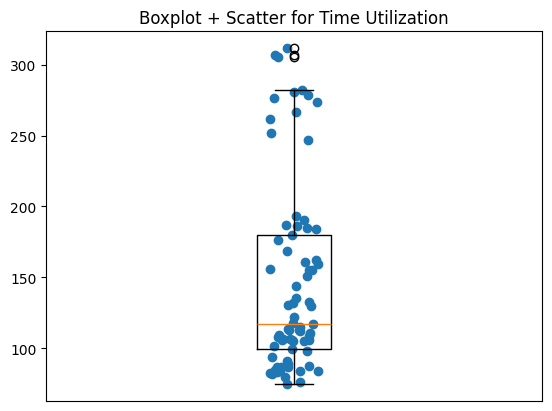

In [17]:
for col in dependant_variables:
    data = df[col].dropna()

    fig, ax = plt.subplots()

    # Boxplot
    ax.boxplot(data, positions=[0])

    # Jitter scatter points so they don't overlap
    jitter = np.random.uniform(-0.05, 0.05, size=len(data))
    ax.scatter(jitter, data)

    # Clean axis labels
    ax.set_title(f"Boxplot + Scatter for {col}")
    ax.set_xticks([])

    plt.savefig(f"boxplot_{col}.png", dpi=300, bbox_inches="tight")

In [18]:
def create_3d_surface_plots(df, independent_variables, dependent_variables, 
                            save_dir='.', show_plots=False):
    """
    Create 3D surface plots for dependent variables against two independent variables.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing all the data
    independent_variables : list
        List of exactly 2 independent variable names [x_var, y_var]
        Example: ["Frac Width", "Num Parallel"]
    dependent_variables : list
        List of dependent variable names to plot
        Example: ["WNS (ns)", "LUTs", "Registers", "DSPs", "Cycles", "MAE", "RMSE"]
    save_dir : str, optional
        Directory to save the plots (default: current directory)
    show_plots : bool, optional
        Whether to display plots interactively (default: False)
    
    Returns:
    --------
    dict : Dictionary with keys 'individual_plots' and 'combined_plot' containing file paths
    
    Example:
    --------
    >>> independent_vars = ["Frac Width", "Num Parallel"]
    >>> dependent_vars = ["WNS (ns)", "LUTs", "Registers", "DSPs", "Cycles", "MAE", "RMSE"]
    >>> files = create_3d_surface_plots(df, independent_vars, dependent_vars)
    """
    
    # Validate inputs
    if len(independent_variables) != 2:
        raise ValueError("Must provide exactly 2 independent variables")
    
    for var in independent_variables + dependent_variables:
        if var not in df.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame columns")
    
    # Extract variable names
    x_var = independent_variables[0]
    y_var = independent_variables[1]
    
    # Get unique values for the independent variables
    x_values = sorted(df[x_var].unique())
    y_values = sorted(df[y_var].unique())
    
    # Create meshgrid
    X, Y = np.meshgrid(x_values, y_values)
    
    # Color maps to cycle through
    colormaps = [cm.viridis, cm.plasma, cm.inferno, cm.magma, 
                 cm.cividis, cm.turbo, cm.coolwarm]
    
    saved_files = {'individual_plots': [], 'combined_plot': None}
    
    print(f"Generating {len(dependent_variables)} 3D surface plots...")
    print(f"Independent variables: {x_var} (X-axis), {y_var} (Y-axis)")
    print(f"X values: {x_values}")
    print(f"Y values: {y_values}")
    print("-" * 60)
    
    # Generate individual plots
    for idx, dep_var in enumerate(dependent_variables):
        print(f"Creating plot {idx+1}/{len(dependent_variables)}: {dep_var}")
        
        # Create pivot table
        pivot_table = df.pivot_table(
            values=dep_var,
            index=y_var,
            columns=x_var,
            aggfunc='mean'
        )
        
        Z = pivot_table.values
        
        # Create figure
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        # Choose colormap
        cmap = colormaps[idx % len(colormaps)]
        
        # Surface plot
        surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                              linewidth=0.5, antialiased=True, alpha=0.9,
                              edgecolor='gray')
        
        # Add projection contours
        ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap=cmap, 
                   alpha=0.3, linewidths=1)
        
        # Labels
        ax.set_xlabel(x_var, fontsize=12, labelpad=10, fontweight='bold')
        ax.set_ylabel(y_var, fontsize=12, labelpad=10, fontweight='bold')
        ax.set_zlabel(dep_var, fontsize=12, labelpad=10, fontweight='bold')
        ax.set_title(f'{dep_var} vs {x_var} and {y_var}',
                    fontsize=14, fontweight='bold', pad=20)
        
        # Colorbar
        cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=8, pad=0.08)
        cbar.set_label(dep_var, rotation=270, labelpad=20, fontsize=10, 
                      fontweight='bold')
        
        # Grid
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Set viewing angle
        ax.view_init(elev=25, azim=45)
        
        # Set tick parameters
        ax.tick_params(labelsize=9)
        
        plt.tight_layout()
        
        # Save
        safe_name = dep_var.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        filename = f"{save_dir}/3d_{safe_name}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        saved_files['individual_plots'].append(filename)
        
        if show_plots:
            plt.show()
        else:
            plt.close()
    
    print("\n✓ All individual plots saved!")
    
    # Create combined grid view
    print("\nCreating combined grid view...")
    
    # Calculate grid dimensions
    n_plots = len(dependent_variables)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(7 * n_cols, 5 * n_rows))
    
    for idx, dep_var in enumerate(dependent_variables, 1):
        pivot_table = df.pivot_table(
            values=dep_var,
            index=y_var,
            columns=x_var,
            aggfunc='mean'
        )
        
        Z = pivot_table.values
        
        ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
        
        surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma,
                              linewidth=0, antialiased=True, alpha=0.9)
        
        ax.set_xlabel(x_var, fontsize=9)
        ax.set_ylabel(y_var, fontsize=9)
        ax.set_zlabel(dep_var, fontsize=9)
        ax.set_title(dep_var, fontsize=11, fontweight='bold', pad=10)
        
        ax.view_init(elev=20, azim=45)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.2)
    
    plt.suptitle(f'All Dependent Variables vs {x_var} and {y_var}',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    combined_filename = f"{save_dir}/3d_combined_grid_view.png"
    plt.savefig(combined_filename, dpi=300, bbox_inches='tight')
    saved_files['combined_plot'] = combined_filename
    
    if show_plots:
        plt.show()
    else:
        plt.close()
    
    print("✓ Combined grid view saved!")
    
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"Total plots generated: {len(saved_files['individual_plots']) + 1}")
    print(f"Individual plots: {len(saved_files['individual_plots'])}")
    print(f"Combined grid: 1")
    print(f"\nFiles saved in '{save_dir}':")
    for filename in saved_files['individual_plots']:
        print(f"  - {filename}")
    print(f"  - {combined_filename}")
    print("=" * 60)
    
    return saved_files

In [19]:
files = create_3d_surface_plots(
        df=df,
        independent_variables=independant_variables,
        dependent_variables=dependant_variables,
        save_dir='.',
        show_plots=False
    )

Generating 11 3D surface plots...
Independent variables: Frac Width (X-axis), Num Parallel (Y-axis)
X values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0)]
Y values: [np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(8.0), np.float64(16.0)]
------------------------------------------------------------
Creating plot 1/11: WNS (ns)
Creating plot 2/11: LUTs
Creating plot 3/11: Registers
Creating plot 4/11: DSPs
Creating plot 5/11: Cycles
Creating plot 6/11: MAE
Creating plot 7/11: RMSE
Creating plot 8/11: Average Utilization
Creating plot 9/11: Clock Period Utilization
Creating plot 10/11: Cycle Utilization
Creating plot 11/11: Time Utilization

✓ All individual plots saved!

Creating combined grid view...
✓ Combined grid view saved!

SUMMARY
Total